# MLP Exercise - fantasy name generation

In [35]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt # for making figures
from src.layers import Linear, BatchNorm1d, LayerNorm1d, Tanh, Dropout
%matplotlib inline


In [36]:
# Get the datasets

import kagglehub

# Download latest version
path = kagglehub.dataset_download("isaacbenge/fantasy-for-markov-generator")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Fern_PC II\.cache\kagglehub\datasets\isaacbenge\fantasy-for-markov-generator\versions\1


In [37]:
# clean data, normalize strings 
import glob
import pandas as pd 
allcsvs = []
for f in glob.glob(path+"/*.csv") + ["./names_clean.csv", "./forgotten_realms_inhabitants_by_race.csv"]:
# for f in ["./forgotten_realms_inhabitants_by_race.csv"]:
    df = pd.read_csv(f, header=None)
    series = (df[0].str.normalize('NFKD')
                   .str.encode('ascii', errors='ignore')
                   .str.decode('utf-8')
                   .str.lower()
                   .str.replace(r'[^\w\s]', '')
                   .str.replace(r'\d+', '', regex=True)
                   .str.replace('/', '')
                   .str.replace('(', '')
                   .str.replace(')', '')
                   .str.replace('"', "'")
                   .str.replace('_', ' ')
                   .str.replace('`', "'")
                   .str.replace('.', "")
                   .str.strip()
                   
                   )

    allcsvs.append(series)

# Adding names from names_clean.csv
words = pd.concat(allcsvs).to_list()


ParserError: Error tokenizing data. C error: out of memory

In [ ]:
print(len(words))
words[:8]

# Debug: Check what characters are actually in the processed words
print(f"\n{'='*60}")
print("CHARACTER ANALYSIS")
print(f"{'='*60}")
all_chars_in_words = set()
for w in words:
  all_chars_in_words.update(w)

  # build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)


46748

CHARACTER ANALYSIS
{1: ' ', 2: "'", 3: ',', 4: '-', 5: 'a', 6: 'b', 7: 'c', 8: 'd', 9: 'e', 10: 'f', 11: 'g', 12: 'h', 13: 'i', 14: 'j', 15: 'k', 16: 'l', 17: 'm', 18: 'n', 19: 'o', 20: 'p', 21: 'q', 22: 'r', 23: 's', 24: 't', 25: 'u', 26: 'v', 27: 'w', 28: 'x', 29: 'y', 30: 'z', 0: '.'}
31


In [ ]:
# build the dataset
block_size = 16 # context length: how many characters do we take to predict the next one?
g = torch.Generator().manual_seed(2147483647) # for reproducibility

def build_dataset(words):  
  X, Y = [], []
  
  # Debug: Track problematic words
  missing_chars = set()
  empty_words = []
  problematic_words = []
  
  for idx, w in enumerate(words):
    # Check for empty strings
    if not w or len(w.strip()) == 0:
      empty_words.append((idx, w))
      continue
    
    context = [0] * block_size
    word_chars = []
    
    try:
      for ch in w + '.':
        if ch not in stoi:
          missing_chars.add(ch)
          problematic_words.append((idx, w, f"Missing char: '{ch}' (ord={ord(ch)})"))
          raise KeyError(f"Character '{ch}' not in stoi")
        ix = stoi[ch]
        word_chars.append((ch, ix))
        X.append(context.copy())
        Y.append(ix)
        context = context[1:] + [ix] # crop and append
    except KeyError as e:
      # Skip this word but continue processing
      if len(problematic_words) <= 10:  # Only print first 10
        print(f"  ERROR at word {idx}: '{w}' - {e}")
      continue
  


  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

print(f"Dataset ready")
print(f"  Training samples: {len(Xtr)}")
print(f"  Validation samples: {len(Xdev)}")
print(f"  Test samples: {len(Xte)}")


torch.Size([360557, 16]) torch.Size([360557])
torch.Size([45603, 16]) torch.Size([45603])
torch.Size([45572, 16]) torch.Size([45572])
Dataset ready
  Training samples: 360557
  Validation samples: 45603
  Test samples: 45572


In [ ]:
n_embd = 32 # the dimensionality of the character embedding vectors
n_hidden = 512 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),            generator=g)

layers = [
  Linear(block_size * n_embd, n_hidden, bias=False), LayerNorm1d(n_hidden), Dropout(0.1), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), LayerNorm1d(n_hidden), Dropout(0.1), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), LayerNorm1d(n_hidden), Dropout(0.1), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), LayerNorm1d(n_hidden), Dropout(0.1), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), LayerNorm1d(n_hidden), Dropout(0.1), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), LayerNorm1d(n_hidden), Dropout(0.1), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), LayerNorm1d(n_hidden), Dropout(0.1), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), LayerNorm1d(n_hidden), Dropout(0.1), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), LayerNorm1d(n_hidden), Dropout(0.1), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), LayerNorm1d(n_hidden), Dropout(0.1), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), LayerNorm1d(n_hidden), Dropout(0.1), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), LayerNorm1d(n_hidden), Dropout(0.1), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), LayerNorm1d(vocab_size),
]
with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

print(f"Total parameters: {sum(p.nelement() for p in parameters)}")

3174942
Total parameters: 3174942


In [38]:
# same optimization as last time
max_steps = 200000
batch_size = 128  
lossi = []
ud = []

# Training setup


for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors: (batch_size, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # flatten to 2D: (batch_size, block_size * n_embd)
  
  # Pass through all layers (attention + normalization are now in the layers list)
  x = embcat
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  
  # update
  lr = 0.2 if i < 150000 else 0.02 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  #if i >= 1000:
  #  break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.4430
  10000/ 200000: 2.3318
  20000/ 200000: 2.0500
  30000/ 200000: 2.4176
  40000/ 200000: 2.1140
  50000/ 200000: 2.1839
  60000/ 200000: 2.0205
  70000/ 200000: 2.1021
  80000/ 200000: 1.9953
  90000/ 200000: 2.0054
 100000/ 200000: 1.8902
 110000/ 200000: 1.8916
 120000/ 200000: 1.8362
 130000/ 200000: 1.9251


KeyboardInterrupt: 

In [39]:

#plt.plot(lossi)
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

RuntimeError: shape '[-1, 1000]' is invalid for input of size 134882

layer 3 (      Tanh): mean -0.00, std 0.80, saturated: 37.61%
layer 7 (      Tanh): mean -0.00, std 0.77, saturated: 29.55%
layer 11 (      Tanh): mean -0.00, std 0.74, saturated: 22.21%
layer 15 (      Tanh): mean -0.00, std 0.71, saturated: 16.74%
layer 19 (      Tanh): mean +0.00, std 0.69, saturated: 13.06%
layer 23 (      Tanh): mean -0.00, std 0.68, saturated: 10.79%
layer 27 (      Tanh): mean +0.00, std 0.67, saturated: 9.18%
layer 31 (      Tanh): mean +0.00, std 0.67, saturated: 8.45%
layer 35 (      Tanh): mean -0.01, std 0.67, saturated: 8.50%
layer 39 (      Tanh): mean +0.00, std 0.68, saturated: 8.78%
layer 43 (      Tanh): mean +0.00, std 0.69, saturated: 9.41%
layer 47 (      Tanh): mean -0.00, std 0.71, saturated: 11.17%


Text(0.5, 1.0, 'activation distribution')

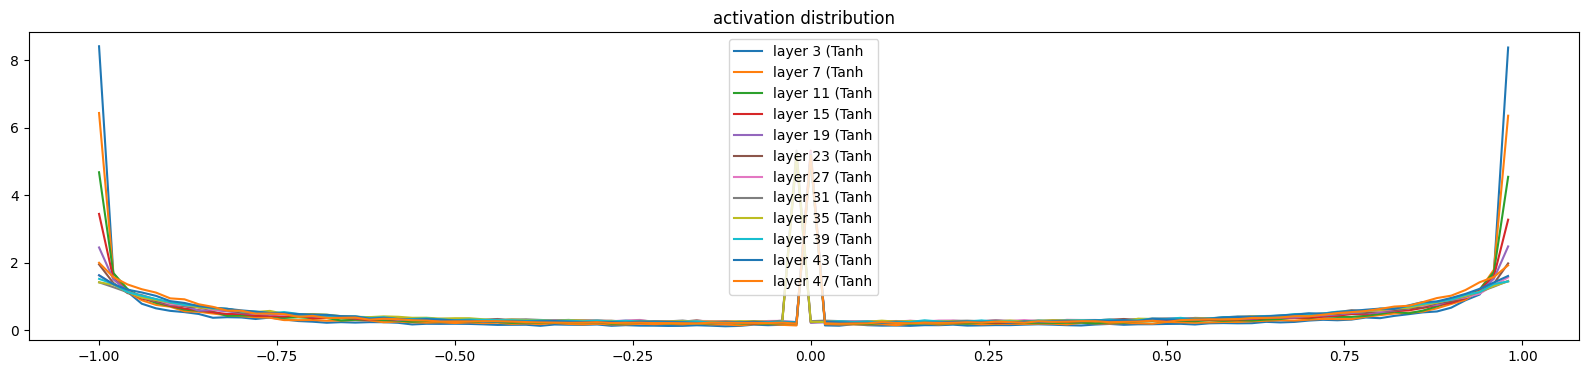

In [40]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.detach().cpu()
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 3 (      Tanh): mean +0.000006, std 4.135247e-04
layer 7 (      Tanh): mean +0.000002, std 3.320578e-04
layer 11 (      Tanh): mean +0.000001, std 2.556111e-04
layer 15 (      Tanh): mean -0.000001, std 2.034467e-04
layer 19 (      Tanh): mean -0.000000, std 1.692841e-04
layer 23 (      Tanh): mean -0.000001, std 1.493686e-04
layer 27 (      Tanh): mean +0.000000, std 1.327891e-04
layer 31 (      Tanh): mean +0.000000, std 1.234441e-04
layer 35 (      Tanh): mean -0.000000, std 1.189870e-04
layer 39 (      Tanh): mean -0.000000, std 1.195967e-04
layer 43 (      Tanh): mean +0.000000, std 1.221627e-04
layer 47 (      Tanh): mean +0.000000, std 1.394776e-04


Text(0.5, 1.0, 'gradient distribution')

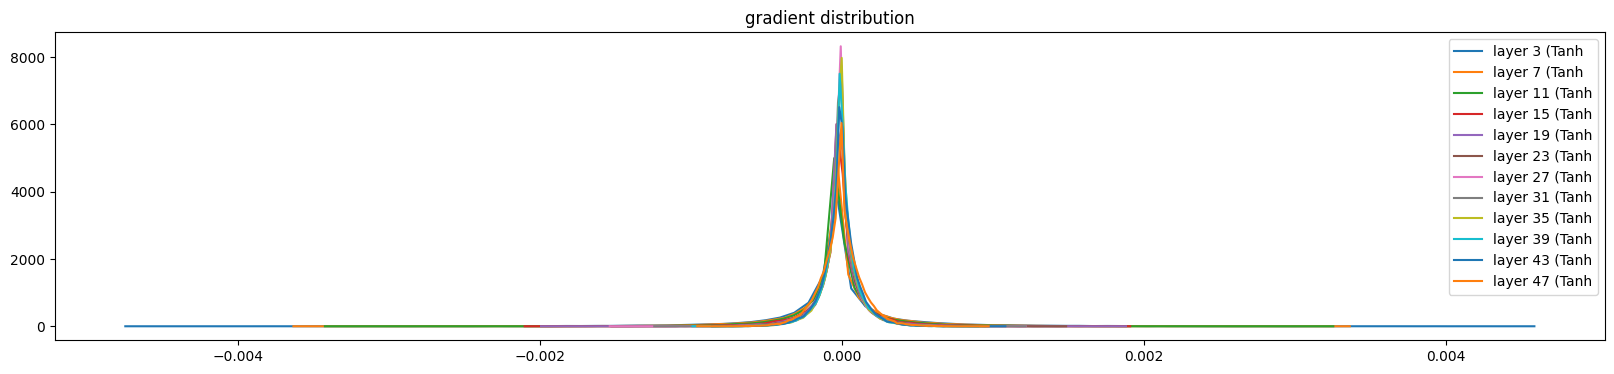

In [41]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh) and hasattr(layer.out, 'grad') and layer.out.grad is not None:
    t = layer.out.grad.detach().cpu()
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (31, 32) | mean -0.000024 | std 6.309874e-03 | grad:data ratio 5.944060e-03
weight (512, 512) | mean +0.000000 | std 1.489716e-03 | grad:data ratio 1.212563e-02
weight (512, 512) | mean -0.000000 | std 1.158400e-03 | grad:data ratio 1.159357e-02
weight (512, 512) | mean -0.000000 | std 8.662664e-04 | grad:data ratio 1.060723e-02
weight (512, 512) | mean -0.000000 | std 6.613510e-04 | grad:data ratio 9.511622e-03
weight (512, 512) | mean -0.000000 | std 5.287078e-04 | grad:data ratio 8.499497e-03
weight (512, 512) | mean -0.000000 | std 4.482662e-04 | grad:data ratio 7.744190e-03
weight (512, 512) | mean +0.000000 | std 3.947872e-04 | grad:data ratio 7.109474e-03
weight (512, 512) | mean -0.000000 | std 3.589602e-04 | grad:data ratio 6.613354e-03
weight (512, 512) | mean -0.000000 | std 3.426334e-04 | grad:data ratio 6.384507e-03
weight (512, 512) | mean +0.000000 | std 3.424089e-04 | grad:data ratio 6.392386e-03
weight (512, 512) | mean -0.000000 | std 3.524044e-04 | grad:data

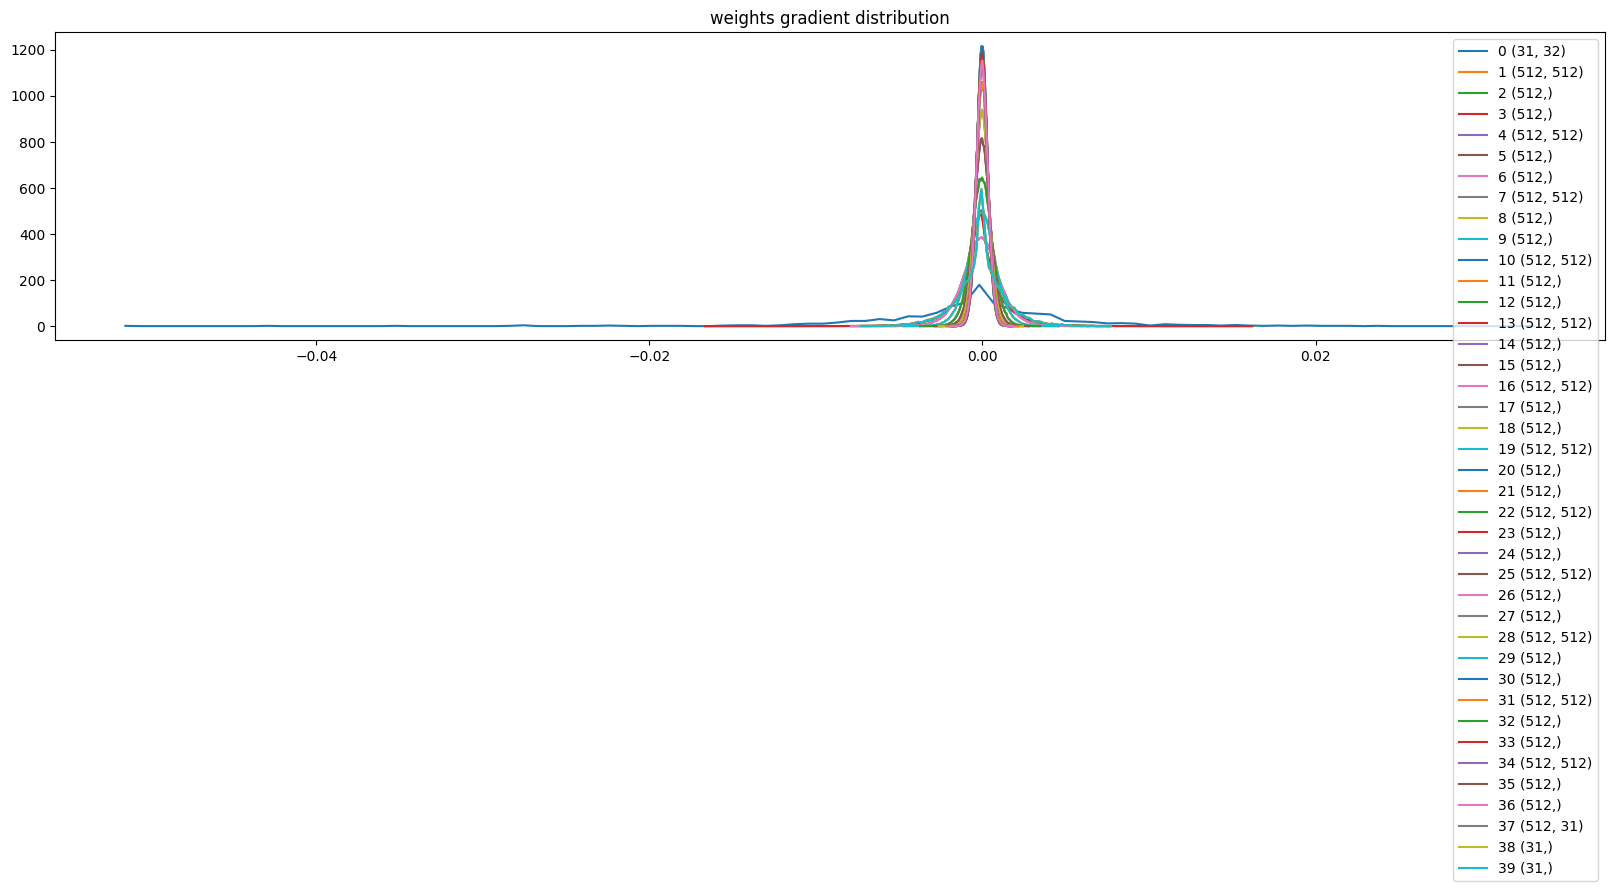

In [42]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  if p.grad is not None:
    t = p.grad.detach().cpu()
    p_cpu = p.detach().cpu()
    if p.ndim == 2:
      print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p_cpu.std()))
      hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

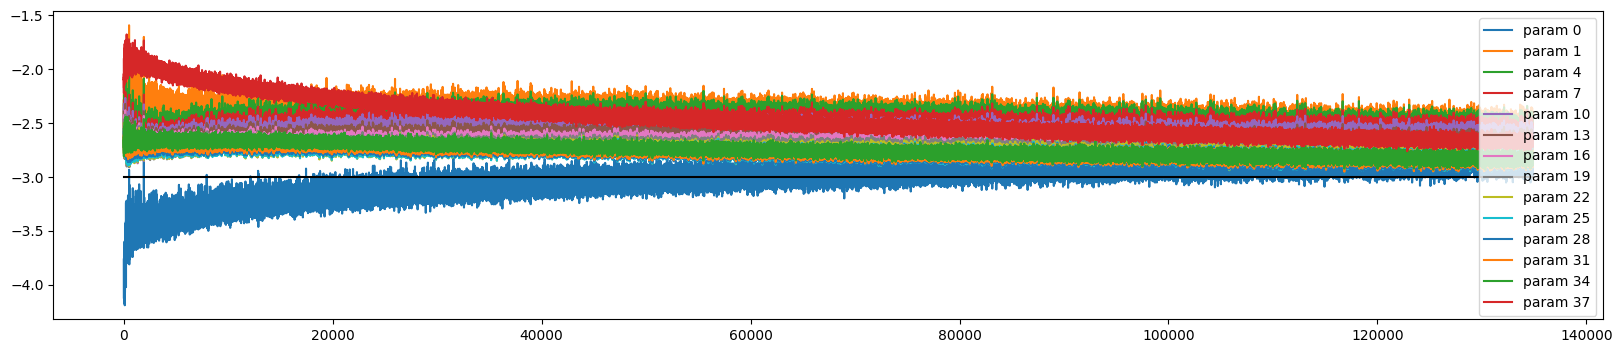

: 

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # flatten to 2D: (N, block_size * n_embd)
  
  # Pass through all layers (attention + normalization are now in the layers list)
  x = embcat
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
# split_loss('train')
split_loss('val')

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 22)

for _ in range(25):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      embcat = emb.view(emb.shape[0], -1) # flatten to 2D: (1, block_size * n_embd)
      
      # Pass through all layers (attention + normalization are now in the layers list)
      x = embcat
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

kidron.
get.
auntasis.
arcad joss.
jong'din.
efreet.
heryn.
lomeoth.
charlinder.
bedell.
gyang.
duiljan.
isakon.
odivanna.
iscalle hoardrow.
rickno.
melden asheroth.
ferno.
gerosles.
ronach.
adrion spawehen.
ssovora.
nathrae sackeya.
rene.
steai kanazis.


In [ ]:
# sample from the model forcing more words
g = torch.Generator().manual_seed(2147483647 + 42)

for _ in range(25):
    has_space = False
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      embcat = emb.view(emb.shape[0], -1) # flatten to 2D: (1, block_size * n_embd)
      
      # Pass through all layers (attention + normalization are now in the layers list)
      x = embcat
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      # if we sample the special '.' token, replace with space if no space, otherwise break
      if itos[ix] == ' ':
        has_space = True
      if ix == 0:
        if has_space==False:
            ix = stoi[' ']
            has_space = True
        else:
            break
      context = context[1:] + [ix]
      out.append(ix)

    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

beldach regdim
veselcrah zabalder
asebekag drien
anta youn'thal
carlay brocksilver
mila malannise
shortakaris al-afirch
perifrederick voydenis
rull sockil
evandro kautlin
adelsan thilmer
maralda brabestone
janon crownster
thul speiros
jimmy hornef thar
umalusathyr chin
jitta tandor
sehael tlathan
challis marin
quasith longun
fredlia brockbell
fillian silverfinge
loannissa one
halma ammarhan
penile fradoweal


In [ ]:
# sample from the model forcing "the"
g = torch.Generator().manual_seed(2147483647 + 67)

for _ in range(25):
    has_the = False
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      embcat = emb.view(emb.shape[0], -1) # flatten to 2D: (1, block_size * n_embd)
      
      # Pass through all layers (attention + normalization are now in the layers list)
      x = embcat
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      # if we sample the special '.' token, replace with space if no space, otherwise break
      if ix == 0:
        if has_the==False:
            context = context[5:] + [stoi[' '], stoi['t'], stoi['h'], stoi['e'], stoi[' ']]
            has_the = True
            out = out + [stoi[' '], stoi['t'], stoi['h'], stoi['e'], stoi[' ']]
        else:
            break
      else:
        context = context[1:] + [ix]
        out.append(ix)

    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

queens the bayn
signashut the lingbin
sheryina the lantless
mong the catchoer
kar sheerim the danin
suzaily the sabaktin
blakrett the namitoun
tyra the laurin
garnisma the shifer
achil divin the drophans mistore
bolakus the sworm
celeste bruncer the barnin
pasherthearthar the gent
steford staryn the bladdic
catso the worphess
orluk the ranter
nikma the disbrenblaq ilichthi
breigar baann the clapper
josyle yowst the lii
irino the tarblow
rosanzah the costrice
omrgo the twilker
chauki the cound
teicio the bladed iee
nik the kaal


In [ ]:
stoi

In [ ]:
C.shape

### from andrejs
train 2.0193495750427246
val 2.156538963317871
### bigger network
train 1.9244529008865356
val 2.1407828330993652
### adjusted sizes + more data
train 1.642111897468567
val 2.2296860218048096

good names tho